# South African Language Identification Hack 2023 (Kaggle)

## Dataset Description

The dataset used for this challenge is the NCHLT Text Corpora collected by the South African Department of Arts and Culture & Centre for Text Technology (CTexT, North-West University, South Africa). The training set was improved through additional cleaning done by Praekelt.

The data is in the form Language ID, Text. The text is in various states of cleanliness. Some NLP techniques will be necessary to clean up the data.

## File Description


train_set.csv - the training set

test_set.csv - the test set

sample_submission.csv - a sample submission file in the correct format
Language IDs

afr - Afrikaans

eng - English

nbl - isiNdebele

nso - Sepedi

sot - Sesotho

ssw - siSwati

tsn - Setswana

tso - Xitsonga

ven - Tshivenda

xho - isiXhosa

zul - isiZulu

## Importing all the packages necessary to work on the dataset

In [48]:
# data loading dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import pickle


# libraries for NLP
import nltk
from nltk.corpus import stopwords
from nltk import SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


# importing libraries for utility from sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier


# importing libraries for modelling form sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


# libraries to check model metrics from sklearn
from sklearn.metrics import confusion_matrix, f1_score, classification_report

# Enable interactive visualisations in Jupyter
from ipywidgets import interact, interact_manual, widgets
import plotly.express as px

#word cloud visualization
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.filterwarnings("ignore")

## Loading Data

In [49]:

train = pd.read_csv('train_set.csv')
test = pd.read_csv('test_set.csv')

#inspect first five rows of train and test set
display(train.head())
display(test.head())

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.


## Exploratory Data Analysis (EDA)

### Descriptive EDA

In [50]:
def data_info(data):
    '''
    This function basically helps to get basic information about the data set
    It should give information on the number of rows, columns, data points and tell us which
    features are numerical or categorical
    '''
    print('1) Number of columns are: ',data.shape[1])
    print('2) Number of rows are: ',data.shape[0])
    print('3) Total number of data-points:',data.size)
    numerical_features = [f for f in data.columns if data[f].dtypes!='O']
    print('4) Count of Numerical Features:',len(numerical_features))
    cat_features = [c for c in data.columns if data[c].dtypes=='O']
    print('5) Count of Categorical Features:',len(cat_features))

In [51]:
print('The train data has the following information:')
data_info(train)

The train data has the following information:
1) Number of columns are:  2
2) Number of rows are:  33000
3) Total number of data-points: 66000
4) Count of Numerical Features: 0
5) Count of Categorical Features: 2


In [52]:
# Checking for missing values
def check_features_with_missing_values(data):
    '''
    This function helps to check features in our data set that has missing value. The basic
    functionality is to provide more context into the following:
    1. Overall calculation of missing values in the data set
    2. Breakdown of features with missing values, the total missing value and the percentage of
       missing values in that column.
    '''
    x = data.isnull().sum().sum()/(data.shape[0]*data.shape[1])*100
    print('Percentage of Overall Missing Values is ' ,round(x,2) ,'%')
    print('Missing Value Estimation :')
    for i in data.columns:
        col_miss = round(data[i].isnull().sum()/len(data[i]) * 100, 2)
        if data[i].isna().sum() > 0:
            print('The Feature',i,'has a total of '+ str(data[i].isna().sum()) + ' missing values which translates to ' +
                 str(col_miss) + '% of values missing in that column')

In [53]:
print('Missing value breakdown: ')
check_features_with_missing_values(train)

Missing value breakdown: 
Percentage of Overall Missing Values is  0.0 %
Missing Value Estimation :


In [54]:
# Checking for duplicates
def check_duplicates(data, column_name):
    """
    This function takes in the data frame and the target column for checking duplicates and returns the
    number of duplicates if detected.
    """
    duplicates = pd.DataFrame(data[column_name].duplicated())
    num_of_duplicates = len(duplicates[duplicates[column_name] == True])
    if num_of_duplicates > 0:
        print("Duplicates detected. We have {} number of duplicate value in the dataset".format(num_of_duplicates))
    else:
        print("No duplicates. All good")

In [55]:
check_duplicates(train,'text')

Duplicates detected. We have 3052 number of duplicate value in the dataset


In [56]:
check_duplicates(test, 'text')

Duplicates detected. We have 223 number of duplicate value in the dataset


### Graphical EDA

In [57]:
#Checking for class balance
def class_distribution(data, class_variable):
    data[class_variable].value_counts().plot(kind = 'bar', figsize =(12,5))
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title('Class Distribution')
    plt.show()

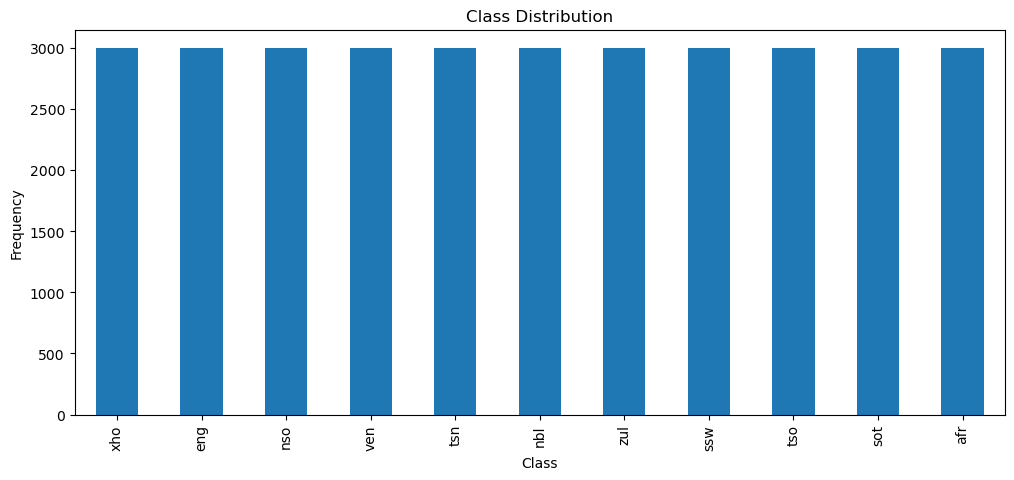

In [58]:
class_distribution(train, 'lang_id')

## Data Preprocessing

In [59]:
#removing duplicate
def remove_duplicates(data):
    """
    This function takes in the dataframe and drops duplicates then return data with dropped duplicates.
    """
    print("Shape before dropping duplicates: {} ".format(data.shape))
    data = data.drop_duplicates()
    print('Shape after dropping duplicates: {}'.format(data.shape))
    return data

In [60]:
train = remove_duplicates(train)

Shape before dropping duplicates: (33000, 2) 
Shape after dropping duplicates: (29948, 2)


In [61]:
test = remove_duplicates(test)

Shape before dropping duplicates: (5682, 2) 
Shape after dropping duplicates: (5682, 2)


### Graphical EDA Post Cleaning

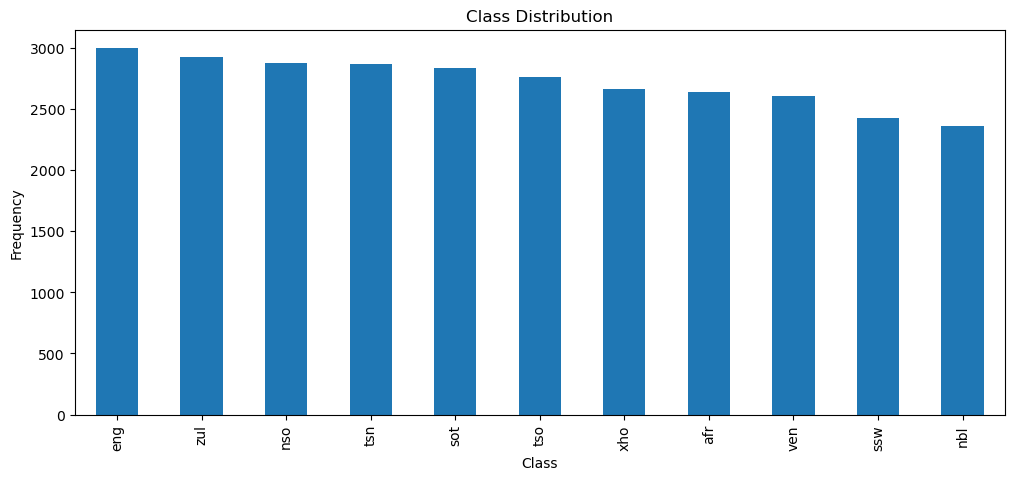

In [62]:
#Checking the effect of dropping duplicates on dataset class
class_distribution(train,'lang_id')

In [63]:
#import string library to form basis for punctuations
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [64]:
def remove_punctuation(text):
    """Takes in a text and removes punctuations"""
    return ''.join([l for l in text if l not in string.punctuation])

In [65]:
def remove_digit(text):
    """Takes in a text and removes number characters"""
    return ''.join([i for i in text if not i.isdigit()])

In [66]:
#applying remove_punctuation and remove_digit function on dataset
train['text'] = train['text'].apply(remove_punctuation,remove_digit)

#applying remove_punctuation and remove_digit function on dataset
test['text'] = test['text'].apply(remove_punctuation,remove_digit)

#### Tokenization: word_tokenize is used to break the text into individual words or tokens.

Output: ['The', 'quick', 'brown', 'foxes', 'are', 'jumping', 'over', 'the', 'lazy', 'dogs']

#### Lemmatization: The WordNet lemmatizer (WordNetLemmatizer) is applied to each token.

Output: ['The', 'quick', 'brown', 'fox', 'are', 'jumping', 'over', 'the', 'lazy', 'dog']

In [67]:
def token_lem (text):
    """Takes in a text and performs the tokenization and lemmatization NLP technique
    and returns the transformed text"""
    
    
    tokens = word_tokenize(text)

    
    # define lemmatiser
    lemmatizer = WordNetLemmatizer()
    lem = [lemmatizer.lemmatize(word) for word in tokens]
   

    return ' '.join([x for x in lem])

In [68]:
#applying tokenization and lemmatization function on dataset
train['text'] = train['text'].apply(token_lem)

#applying tokenization and lemmatization function on dataset
test['text'] = train['text'].apply(token_lem)

### Feature Engineering

In [69]:
lr = LogisticRegression(random_state=42,multi_class='ovr',n_jobs=1, C=1e5,max_iter=4000)


#Instializing the pipeline
pipe = Pipeline([(
    'vect', CountVectorizer(stop_words='english', 
                             min_df=1, 
                             max_df=0.9, 
                             ngram_range=(1, 3))),
    ('tfidf', TfidfTransformer()),
    ('model', lr)])


### Modeling

We will consider different Machine Learning algorithms for tthis classification tasks. 
They include:
* Logistics Regression
* Naive Bayes (Multinomial Model)
* Random Forest Classifier

### Splitting dataset into train and validation set

In [70]:
#Defining features and target
X = train['text']
y = train['lang_id']

In [71]:
# splitting into train and validating with sklearn.train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=45)

In [72]:
def train_model(model, X_train, y_train, X_test, y_test):
    #building pipeline
    pipe = Pipeline([(
    'vect', CountVectorizer(stop_words='english', 
                             min_df=1, 
                             max_df=0.9, 
                             ngram_range=(1, 3))),
    ('tfidf', TfidfTransformer()),
    ('model', model)])
    
    #training model
    pipe.fit(X_train,y_train)
    
    #getting predictions
    prediction = pipe.predict(X_test)
    
    #classification report
    print(classification_report(y_test,prediction))

#### Logistic Regression

In [73]:
#Initializing the model
lr = LogisticRegression(random_state=42,multi_class='ovr',n_jobs=1, C=1e5,max_iter=4000)

In [74]:
#training process
train_model(lr, X_train, y_train, X_test, y_test)

KeyboardInterrupt: 

#### Linear Support Vector Classifier

In [ ]:
svc = SVC()

In [ ]:
train_model(svc, X_train, y_train, X_test, y_test)

#### Naive Bayes MultinomialNB

In [ ]:
naive = MultinomialNB()

In [ ]:
train_model(naive, X_train, y_train, X_test, y_test)

In [ ]:
### Model Performance

In [ ]:
### Submission

In [ ]:
# Preparing train and test data for Kaggle submission
X_train_full = train['text']
y_train_full = train['lang_id']
X_test_full = test['text']

In [ ]:
kaggle_pipe = Pipeline([('vect',CountVectorizer(stop_words='english',
                                         min_df=2,
                                         max_df=0.9,
                                         ngram_range=(3,6),analyzer=('char'))),
                 ('tfidf',TfidfTransformer()),
                 ('model',lr)])

In [ ]:
kaggle_pipe.fit(X_train_full, y_train_full)

In [ ]:
y_pred = kaggle_pipe.predict(X_test_full)

In [ ]:
# Submission to Kaggle
submit = test.index + 1
Final_Table = {'index': submit, 'lang_id': y_pred}
submission = pd.DataFrame(data=Final_Table)
submission = submission[['index', 'lang_id']]

# Saving submission as CSV file
submission.to_csv('submission1.csv', index=False)